In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shie/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

src = "/home/vishu/data/hbmep-processed/L_SHIE/mat.npy"
mat = np.load(src)
mat = mat[~ind, ...]

time = np.linspace(-0.01, 0.025, mat.shape[1])

""" Process """
df, encoder_dict = model.load(df=df)


2023-09-12 10:24:35,923 - hbmep.config - INFO - Verifying configuration ...
2023-09-12 10:24:35,924 - hbmep.config - INFO - Success!
2023-09-12 10:24:35,937 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-09-12 10:24:35,980 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-09-12 10:24:35,981 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-09-12 10:24:35,982 - hbmep.dataset.core - INFO - Processing data ...
2023-09-12 10:24:35,983 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
df.shape

(3392, 46)

In [4]:
mat.shape

(3392, 428, 8)

In [5]:
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x size
combinations_inv = [
    (
        encoder_dict[model.subject].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[0]].inverse_transform(np.array([c[1]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[2]]))[0]
    ) for c in combinations
]

conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x size
conditions_inv = [
    (
        encoder_dict[model.features[0]].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[1]]))[0]
    ) for c in conditions
]

In [6]:
len(combinations)

64

In [7]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]

muscles_map = {
    "adm": "auc_1",
    "biceps": "auc_2",
    "deltoid": "auc_4",
    "ecr": "auc_5",
    "fcr": "auc_6",
    "triceps": "auc_7"
}

n_muscles = len(muscles)

In [8]:
a = None
b = None
L = None
H = None
v = None

for muscle in muscles:
    a_muscle = None
    b_muscle = None
    L_muscle = None
    H_muscle = None
    v_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/L_SHIE/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}/{c_inv[2]}"
        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0, 0]
        a_temp = a_temp[..., None]

        b_temp = mcmc[site.b].to_numpy()
        b_temp = b_temp[..., 0, 0, 0, 0]
        b_temp = b_temp[..., None]

        L_temp = mcmc[site.L].to_numpy()
        L_temp = L_temp[..., 0, 0, 0, 0]
        L_temp = L_temp[..., None]

        H_temp = mcmc[site.H].to_numpy()
        H_temp = H_temp[..., 0, 0, 0, 0]
        H_temp = H_temp[..., None]

        v_temp = mcmc[site.v].to_numpy()
        v_temp = v_temp[..., 0, 0, 0, 0]
        v_temp = v_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
            b_muscle = b_temp
            L_muscle = L_temp
            H_muscle = H_temp
            v_muscle = v_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)
            b_muscle = np.concatenate((b_muscle, b_temp), axis=-1)
            L_muscle = np.concatenate((L_muscle, L_temp), axis=-1)
            H_muscle = np.concatenate((H_muscle, H_temp), axis=-1)
            v_muscle = np.concatenate((v_muscle, v_temp), axis=-1)

    a_muscle = a_muscle[..., None]
    b_muscle = b_muscle[..., None]
    L_muscle = L_muscle[..., None]
    H_muscle = H_muscle[..., None]
    v_muscle = v_muscle[..., None]

    if a is None:
        a = a_muscle
        b = b_muscle
        L = L_muscle
        H = H_muscle
        v = v_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)
        b = np.concatenate((b, b_muscle), axis=-1)
        L = np.concatenate((L, L_muscle), axis=-1)
        H = np.concatenate((H, H_muscle), axis=-1)
        v = np.concatenate((v, v_muscle), axis=-1)

In [9]:
a = a.reshape(-1, *a.shape[2:])
b = b.reshape(-1, *b.shape[2:])
L = L.reshape(-1, *L.shape[2:])
H = H.reshape(-1, *H.shape[2:])
v = v.reshape(-1, *v.shape[2:])

In [10]:
a.shape

(24000, 64, 6)

In [11]:
a_map = a.mean(axis=0)
a_map.shape

(64, 6)

In [12]:
x = None

for muscle in muscles:
    x_muscle = None

    for i, c in enumerate(combinations):
        ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        lo, hi = temp_df[model.intensity].min(), temp_df[model.intensity].max()
        x_temp = np.linspace(lo, hi, 100)
        x_temp = x_temp[..., None]

        if x_muscle is None:
            x_muscle = x_temp
        else:
            x_muscle = np.concatenate((x_muscle, x_temp), axis=-1)

    x_muscle = x_muscle[..., None]

    if x is None:
        x = x_muscle
    else:
        x = np.concatenate((x, x_muscle), axis=-1)

x = x[:, None, ...]

In [13]:
x.shape

(100, 1, 64, 6)

In [14]:
y = L + jnp.maximum(
    0,
    -1
    + (H + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H, v) - 1)
        * jnp.exp(-b * (x - a)),
        1 / v
    )
)
y.shape

(100, 24000, 64, 6)

In [15]:
y_map = y.mean(axis=1)
y_map.shape

(100, 64, 6)

In [16]:
y_max = None

for i, (sub, pos, charge) in enumerate(combinations):
    com = [(j, c) for j, c in enumerate(combinations) if c[0] == sub]
    ind = [v[0] for v in com]

    y_max_temp = y_map[:, ind, ...].max(axis=(0, 1)).reshape(-1,)
    y_max_temp = y_max_temp[None, ...]

    if y_max is None:
        y_max = y_max_temp
    else:
        y_max = np.concatenate((y_max, y_max_temp), axis=0)

y_max = y_max[None, None , ...]
y_max.shape

(1, 1, 64, 6)

In [17]:
pal = sns.color_palette().as_hex()
pal

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [18]:
a_ = a
# a_[:, 17, 5] = a[:, 17, 5] + 3

a_map_ = a_.mean(axis=0)

# y_ = L + jnp.maximum(
#     0,
#     -1
#     + (H + 1)
#     / jnp.power(
#         1
#         + (jnp.power(1 + H, v) - 1)
#         * jnp.exp(-b * (x - a_)),
#         1 / v
#     )
# )
y_ = y

y_map_ = y_.mean(axis=1)

In [21]:
for i, (c, muscle, color, _) in enumerate(ccs):
    if muscle == "FCR":
        c_ind = [i for i, c_ in enumerate(combinations) if c == c_][0]

        ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()
        temp_mat = mat[ind, ...]

        auc_muscle = muscles_map[muscle]
        muscle_ind = [i for i, muscle_ in enumerate(muscles) if muscle_ == muscle][0]
        mat_muscle_ind = int(auc_muscle.split("_")[1]) - 1

        x_temp = x[:, 0, c_ind, muscle_ind]
        y_temp = y[:, :, c_ind, muscle_ind]

        ax = axes[0, i]
        for k in range(temp_mat.shape[0]):
            x_mat = temp_mat[k, :, mat_muscle_ind] / n_const[i] + temp_df[model.intensity].values[k]
            ax.plot(x_mat, time * 1000, color=color, alpha=eeg_alpha, linewidth=eeg_lw)

In [22]:
x_mat.shape

(428,)

In [23]:
temp_df.shape

(50, 46)

In [24]:
muscles_map

{'adm': 'auc_1',
 'biceps': 'auc_2',
 'deltoid': 'auc_4',
 'ecr': 'auc_5',
 'fcr': 'auc_6',
 'triceps': 'auc_7'}

In [26]:
temp_mat.shape

(50, 428, 8)

In [25]:
temp_mat[np.argmax(temp_df["auc_6"]), :, muscle_ind].shape

(428,)

In [27]:
np.argmax(temp_df["auc_6"])

35

In [28]:
arr = temp_mat[np.argmax(temp_df["auc_6"]) + 1, :, muscle_ind]

In [29]:
arr.shape

(428,)

In [30]:
arr.max() -  arr.min()

2048.6098513549555

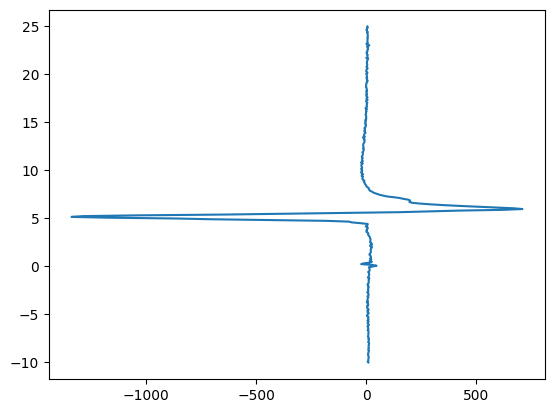

In [31]:
plt.plot(arr, time * 1000, color=color)


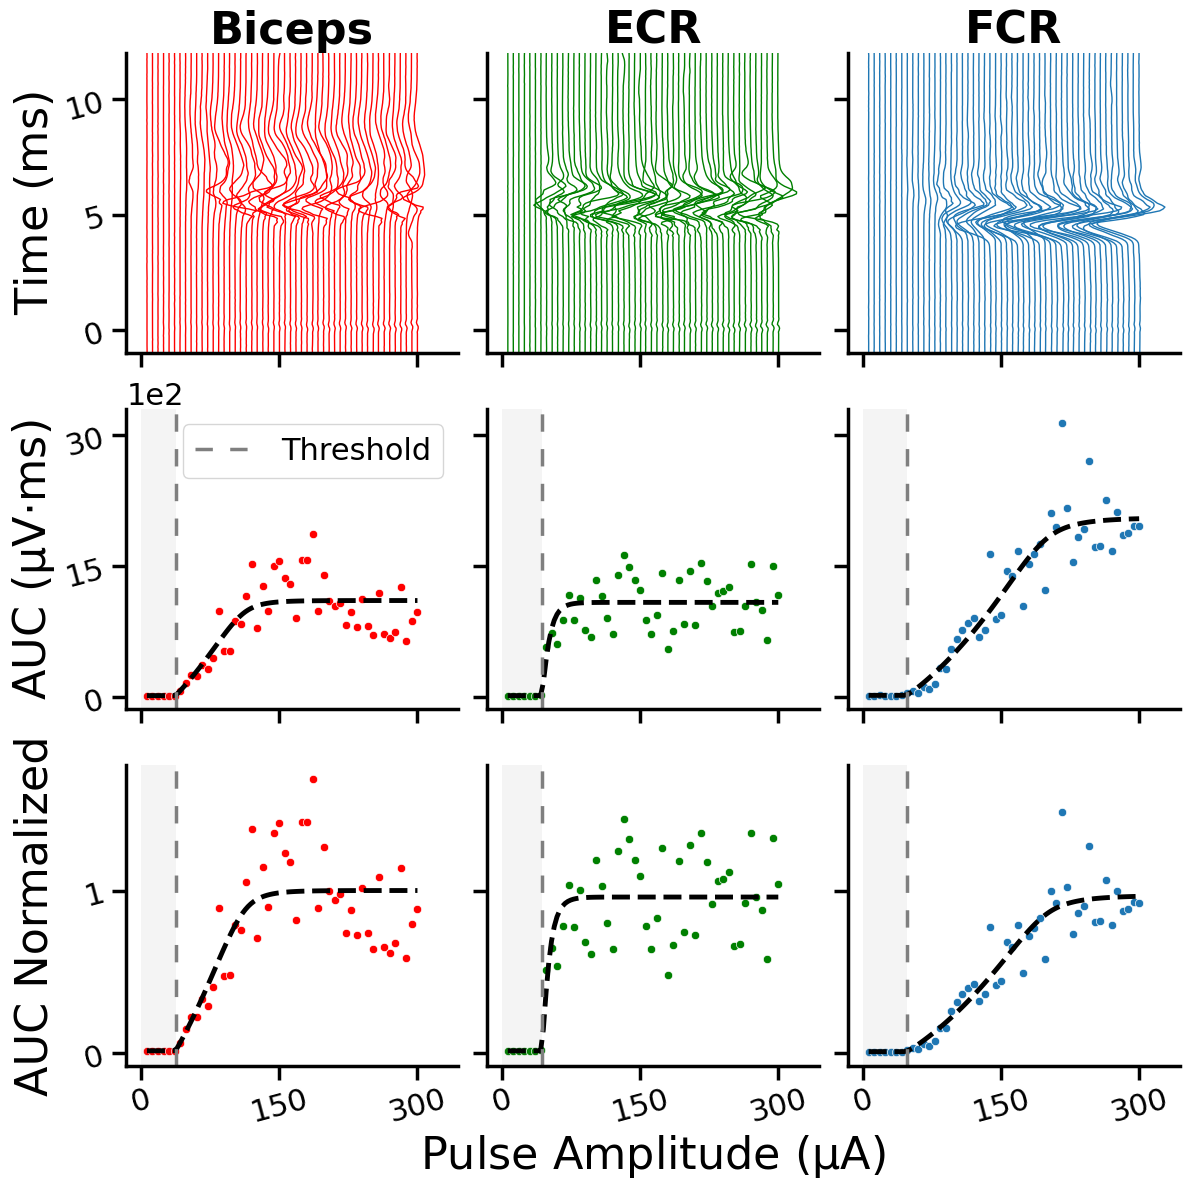

In [20]:
axes_width = 2.5

axis_label_size = 32
tick_size = 22
eeg_lw = 1
eeg_alpha = 1
scatter_alpha = 1
fit_lw = 3.5
th_col, th_lw = pal[-3], 2.5
th_alpha = 1
fw = "normal"
shade_alpha = 0.08
marker_len = 10
marker_width = axes_width

legend_prop = {
    "weight": fw,
    "size": tick_size
}

n_const = np.array([40, 40, 40])
fill_color = pal[-3]
# n_const = np.array([30] * 6)

combi = (2, 3, 1)
combi = (2, 0, 1)

# combi = (7, 1, 1)
ccs = [
    # (combi, "deltoid", pal[6], "Deltoid"),
    (combi, "biceps", 'r', "Biceps"),
    # (combi, "triceps", pal[0], "Triceps"),
    (combi, "ecr", 'g', "ECR"),
    (combi, "fcr", '#1f77b4', "FCR"),
    # (combi, "adm", "g", "ADM")
]


nrows, ncols = 3, len(ccs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharex=True, sharey="row", tight_layout=True)

for i, (c, muscle, color, _) in enumerate(ccs):
    c_ind = [i for i, c_ in enumerate(combinations) if c == c_][0]

    ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()
    temp_mat = mat[ind, ...]

    auc_muscle = muscles_map[muscle]
    muscle_ind = [i for i, muscle_ in enumerate(muscles) if muscle_ == muscle][0]
    mat_muscle_ind = int(auc_muscle.split("_")[1]) - 1

    x_temp = x[:, 0, c_ind, muscle_ind]
    y_temp = y[:, :, c_ind, muscle_ind]

    ax = axes[0, i]
    for k in range(temp_mat.shape[0]):
        x_mat = temp_mat[k, :, mat_muscle_ind] / n_const[i] + temp_df[model.intensity].values[k]
        ax.plot(x_mat, time * 1000, color=color, alpha=eeg_alpha, linewidth=eeg_lw)

    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("")

    ax.set_ylim(bottom=-0.001 * 1000, top=0.012 * 1000)
    ax.set_yticks([0.0 * 1000, 0.005 * 1000, 0.01 * 1000])

    # ax.set_ylim(bottom=0.0015, top=0.01)
    # ax.set_yticks([0.005, 0.01])

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )

    ax = axes[1, i]

    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[muscles_map[muscle]] * 1000, color=color, alpha=scatter_alpha, ax=ax)
    sns.lineplot(x=x_temp, y=y_map_[:, c_ind, muscle_ind] * 1000, ax=ax, color="black", linestyle="--", linewidth=fit_lw)

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )
    # ax.set_yticks([0.0 * 1000, 1 * 1000, 2 * 1000, 3 * 1000])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(2,2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.axvline(a_map_[c_ind, muscle_ind], color=th_col, linestyle="--", dashes=(5, 5), linewidth=th_lw, label="Threshold", alpha=th_alpha)
    ax.axvspan(0, a_map_[c_ind, muscle_ind], facecolor=fill_color, alpha=shade_alpha)

    ax = axes[2, i]
    sns.scatterplot(x=temp_df[model.intensity], y=(temp_df[muscles_map[muscle]] / y_max[0, 0, c_ind, muscle_ind]), color=color, alpha=scatter_alpha, ax=ax)
    sns.lineplot(x=x_temp, y=(y_map_[:, c_ind, muscle_ind] / y_max[0, 0, c_ind, muscle_ind]), ax=ax, color="black", linestyle="--", linewidth=fit_lw)

    ax.axvline(a_map_[c_ind, muscle_ind], color=th_col, linestyle="--", dashes=(5, 5), linewidth=th_lw, label="Threshold", alpha=th_alpha)
    ax.axvspan(0, a_map_[c_ind, muscle_ind], facecolor=fill_color, alpha=shade_alpha)

    # ax.axvline(a_map[c_ind, muscle_ind], color=th_col, linestyle="--", dashes=(5, 5), linewidth=th_lw, label="Threshold", alpha=th_alpha)
    # ax.axvspan(0, a_map[c_ind, muscle_ind], facecolor='r', alpha = 0.08)

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelrotation=15,
        labelsize=tick_size,
        length=marker_len,
        width=marker_width
    )
    # ax.set_yticks([0.0 * 1000, 1 * 1000, 2 * 1000, 3 * 1000])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0, 150, 300])


ax = axes[0, 0]
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_ylabel("Time $($ms$)$", size=axis_label_size, fontweight=fw)

ax = axes[1, 0]
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_ylabel("AUC $($µV$\cdot$ms$)$", size=axis_label_size, fontweight=fw)
ax.set_yticks(np.array([0, 15, 30]) * 100)
ax.legend(loc="upper right", prop=legend_prop)
ax.yaxis.offsetText.set_fontsize(tick_size)

ax = axes[2, 0]
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_yticks(np.array([0, 1]))
ax.set_ylabel("AUC Normalized", size=axis_label_size, fontweight=fw)
# ax.set_xlabel("Pulse Amplitude $($µA$)$", size=axis_label_size, fontweight=fw)
ax.xaxis.offsetText.set_fontsize(tick_size)



for i in range(len(ccs)):
    ax = axes[0, i]
    color, muscle = ccs[i][2], ccs[i][3]
    ax.set_title(muscle, size=axis_label_size, fontweight="bold")

ax = axes[2, 1]
ax.set_xlabel("Pulse Amplitude $($µA$)$", size=axis_label_size, fontweight=fw)

fig.align_ylabels(axes[:, 0])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axes_width)

plt.show()
fig.savefig("/home/vishu/paper/figs/fig_1_A.svg", dpi=600)

In [21]:
y = y / y_max

In [22]:
y_ratio = y / y.sum(axis=-1)[..., None]
y_ratio.shape

(100, 24000, 64, 6)

In [23]:
y_ratio_map = y_ratio.mean(axis=1)
y_ratio_map.shape

(100, 64, 6)

In [24]:
y_ratio_map.max(axis=0).shape

(64, 6)

In [25]:
a_map.shape

(64, 6)

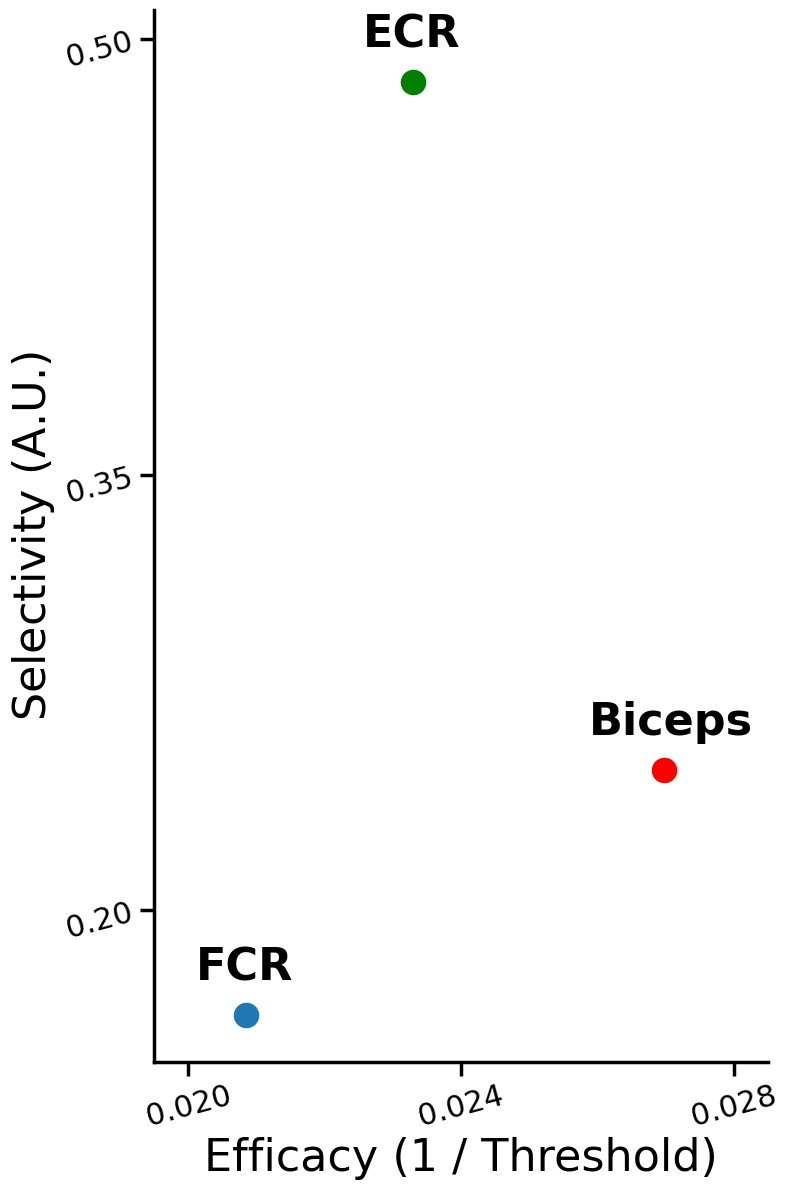

In [32]:
MUSCLES = ["Deltoid", "Biceps", "Triceps", "ECR", "FCR", "ADM"]
ms = 400
alep = 1
infw = "bold"

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 12), tight_layout=True, squeeze=False)
ax = axes[0, 0]

for c, muscle, color, Muscle in ccs:
    c_ind = [i for i, c_ in enumerate(combinations) if c == c_][0]
    muscle_ind = [i for i, m in enumerate(muscles) if muscle == m][0]

    xval = 1 / a_map[c_ind, muscle_ind]
    yval = y_ratio_map.max(axis=0)[c_ind, muscle_ind].item()

    sns.scatterplot(x=[xval], y=[yval], ax=ax, s=ms, alpha=alep, color=color)
    if Muscle == "ECR" or Muscle == "FCR":
        offset = .00074
    if Muscle == "Biceps":
        offset = 0.0011
    ax.text(
        xval - offset, yval + 0.012, Muscle, horizontalalignment='left', weight=infw, size=axis_label_size
    )

# ax.ticklabel_format(axis='x', style='sci', scilimits=(0,2))
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Efficacy (1 / Threshold)", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.set_xlim(left=1.95 / 100, right=2.85 / 100)
ax.set_xticks(np.array([2, 2.4, 2.8]) / 100)

ax.set_ylim(top=5.1 / 10)
ax.set_yticks(np.array([2, 3.5, 5]) / 10)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/fig_1_B.svg", dpi=600)

In [21]:
x_circ = [0.006066207137221817, 0.007300384602773682, 0.011231647577790322, 0.007713310471720916]
y_circ = [0.20599348634109976, 0.2324632170328601, 0.25096967989076246, 0.21403629898769463]
circ_labels = ['E-W', 'NE-SW', 'S-N', 'SE-NW']

x_shield = [0.00683049, 0.00494473, 0.00484568, 0.00878172]
y_shield = [0.22573828, 0.23206649, 0.23503636, 0.26072792]
shield_labels = ['-C Pseudo monophasic', 'C- Pseudo monophasic', 'C-X Pseudo monophasic', 'X-C Pseudo monophasic']


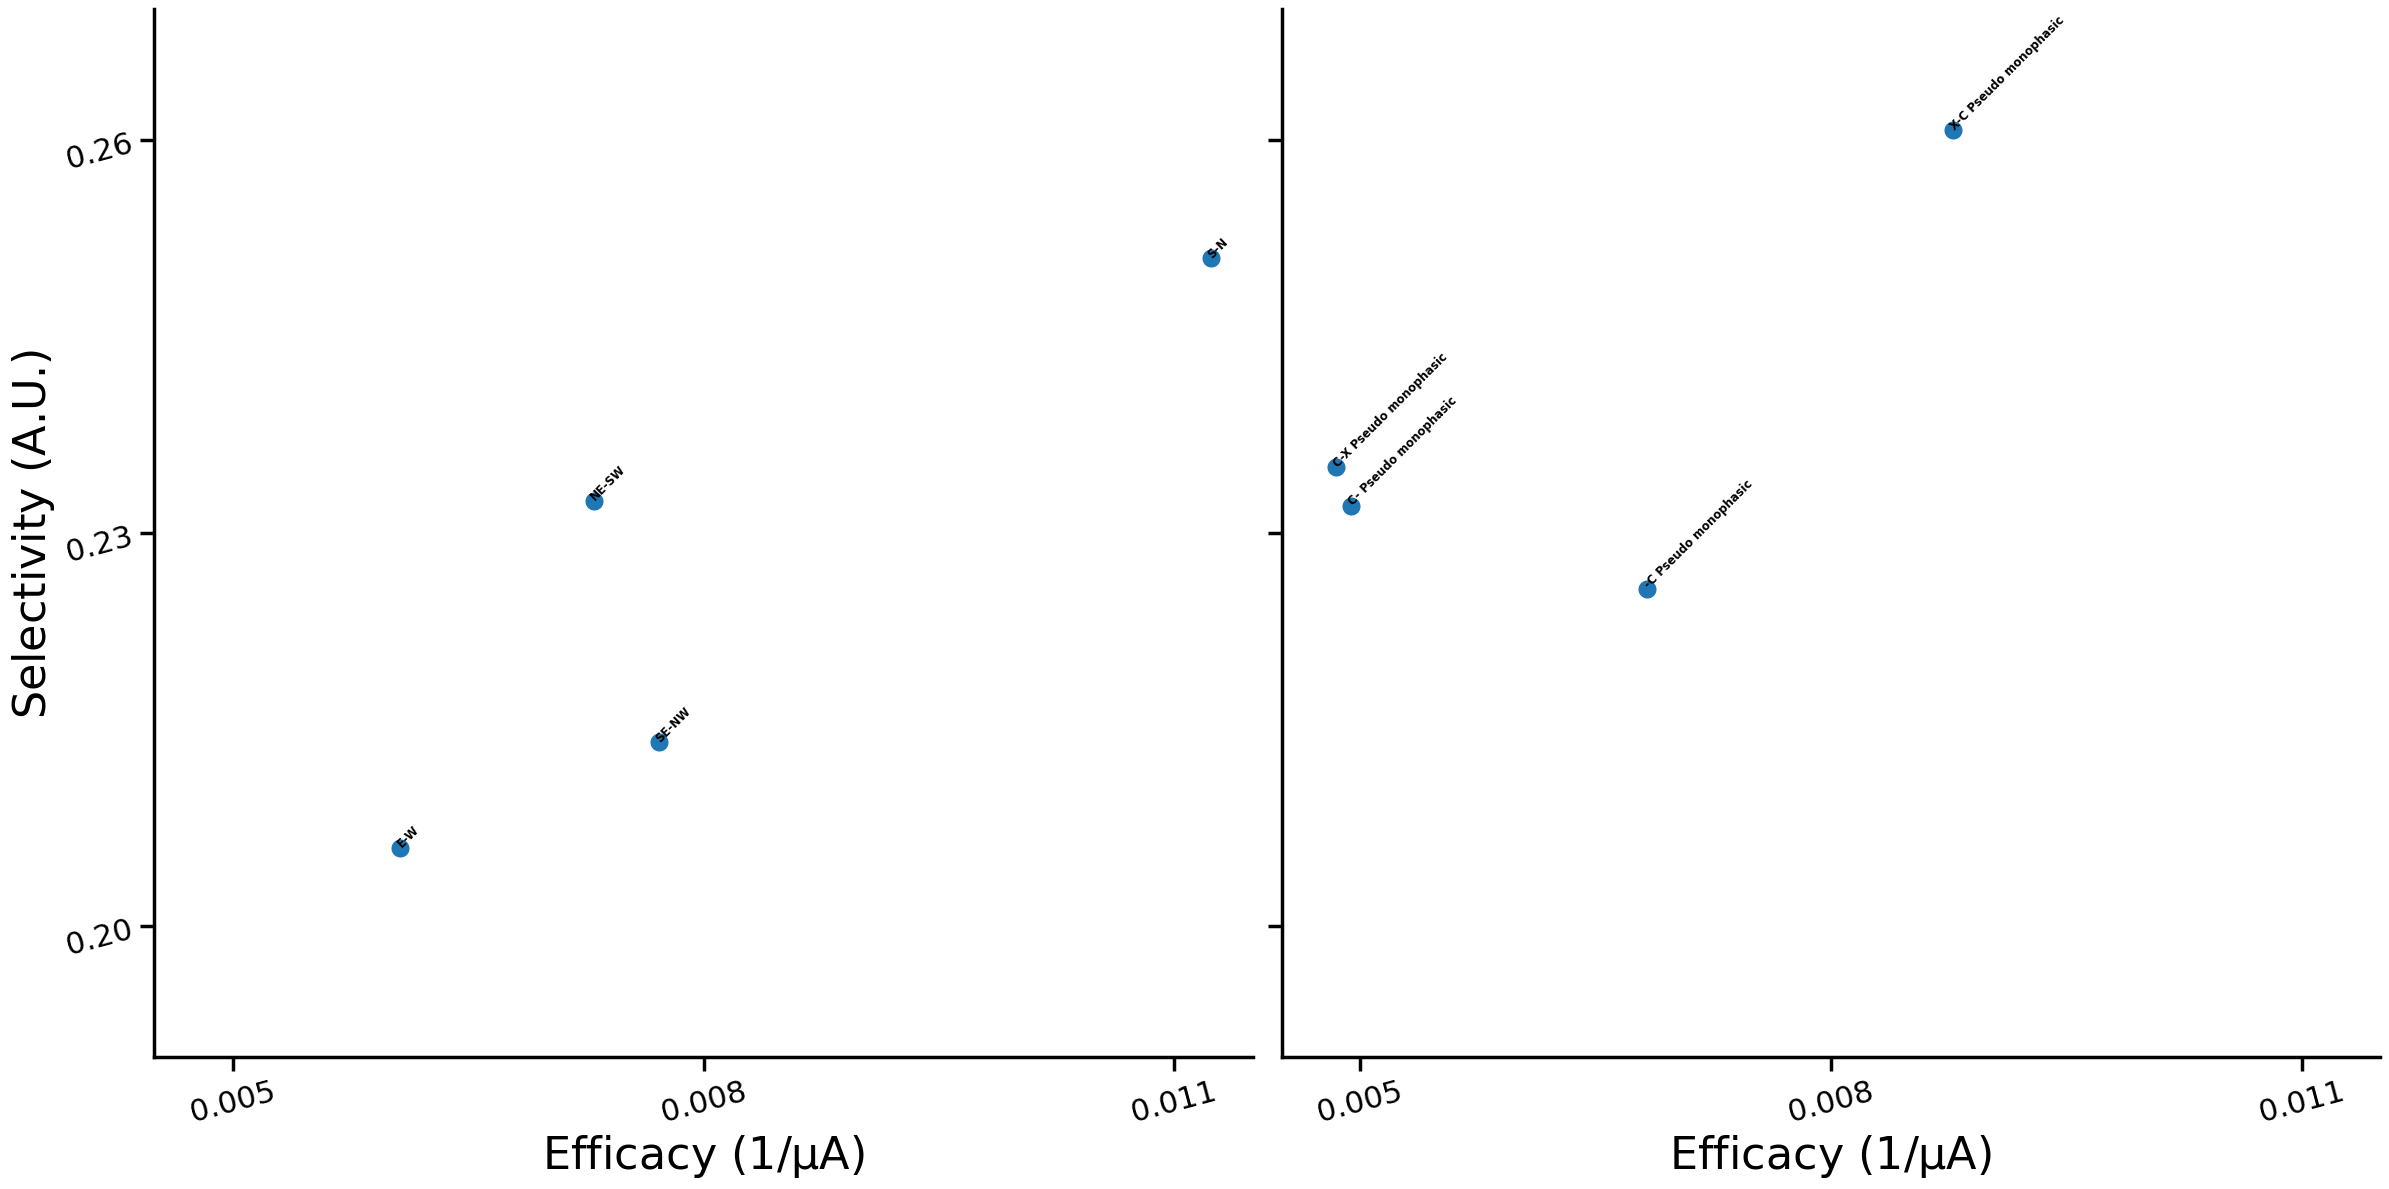

In [23]:
fw = "normal"

axis_label_size = 32
tick_size = 22
axes_width = 2.5

marker_len = 10
marker_width = axes_width

pt_size = 200

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 12), tight_layout=True, squeeze=False, sharey=True, sharex=True)

ax = axes[0, 0]
sns.scatterplot(x=x_circ, y=y_circ, ax=ax, s=pt_size)
for i in range(len(circ_labels)):
    ax.text(x_circ[i]+0.00001, y_circ[i]+0.00005,
    circ_labels[i], horizontalalignment='left',
    size='small', color='black', weight='semibold', rotation=45, wrap=True)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)

ax.set_yticks([0.2, 0.23, 0.26])
ax.set_ylim(bottom=0.19, top=0.27)

ax.set_xticks(np.array([0.5, 0.8, 1.1]) / 100)
ax.set_xlim(left=0.45 / 100, right=1.15 / 100)

ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)



ax = axes[0, 1]
sns.scatterplot(x=x_shield, y=y_shield, ax=ax, s=pt_size)
for i in range(len(shield_labels)):
    ax.text(x_shield[i]+0.00001, y_shield[i]+0.00005,
    shield_labels[i], horizontalalignment='left',
    size='small', color='black', weight='semibold', rotation=45, wrap=True)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/fig-2-background.svg", dpi=600)

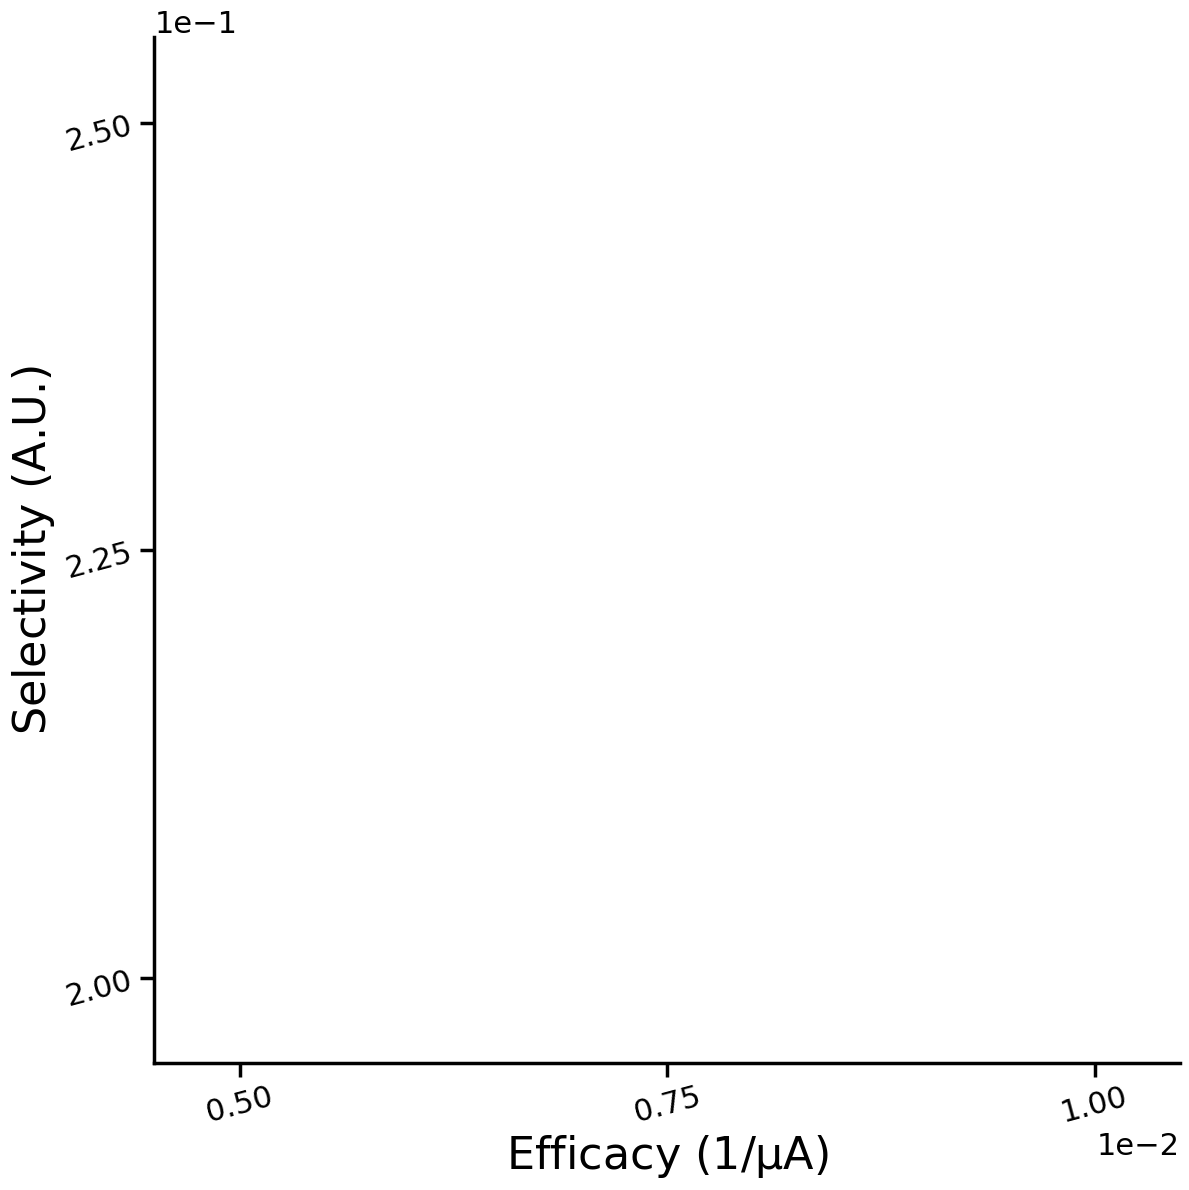

In [184]:
# axis_label_size = 24
# tick_size = 20
fw = "normal"

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), tight_layout=True, squeeze=False)

ax = axes[0, 0]

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

ax.set_xlim(left=0.45/100, right=1.05 / 100)
ax.set_ylim(bottom=1.95/10, top=2.55/10)
ax.set_yticks(np.array([2, 2.25, 2.5]) / 10)
ax.set_xticks(np.array([0.5, 0.75, 1]) / 100)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/plane-circ.svg", dpi=600)


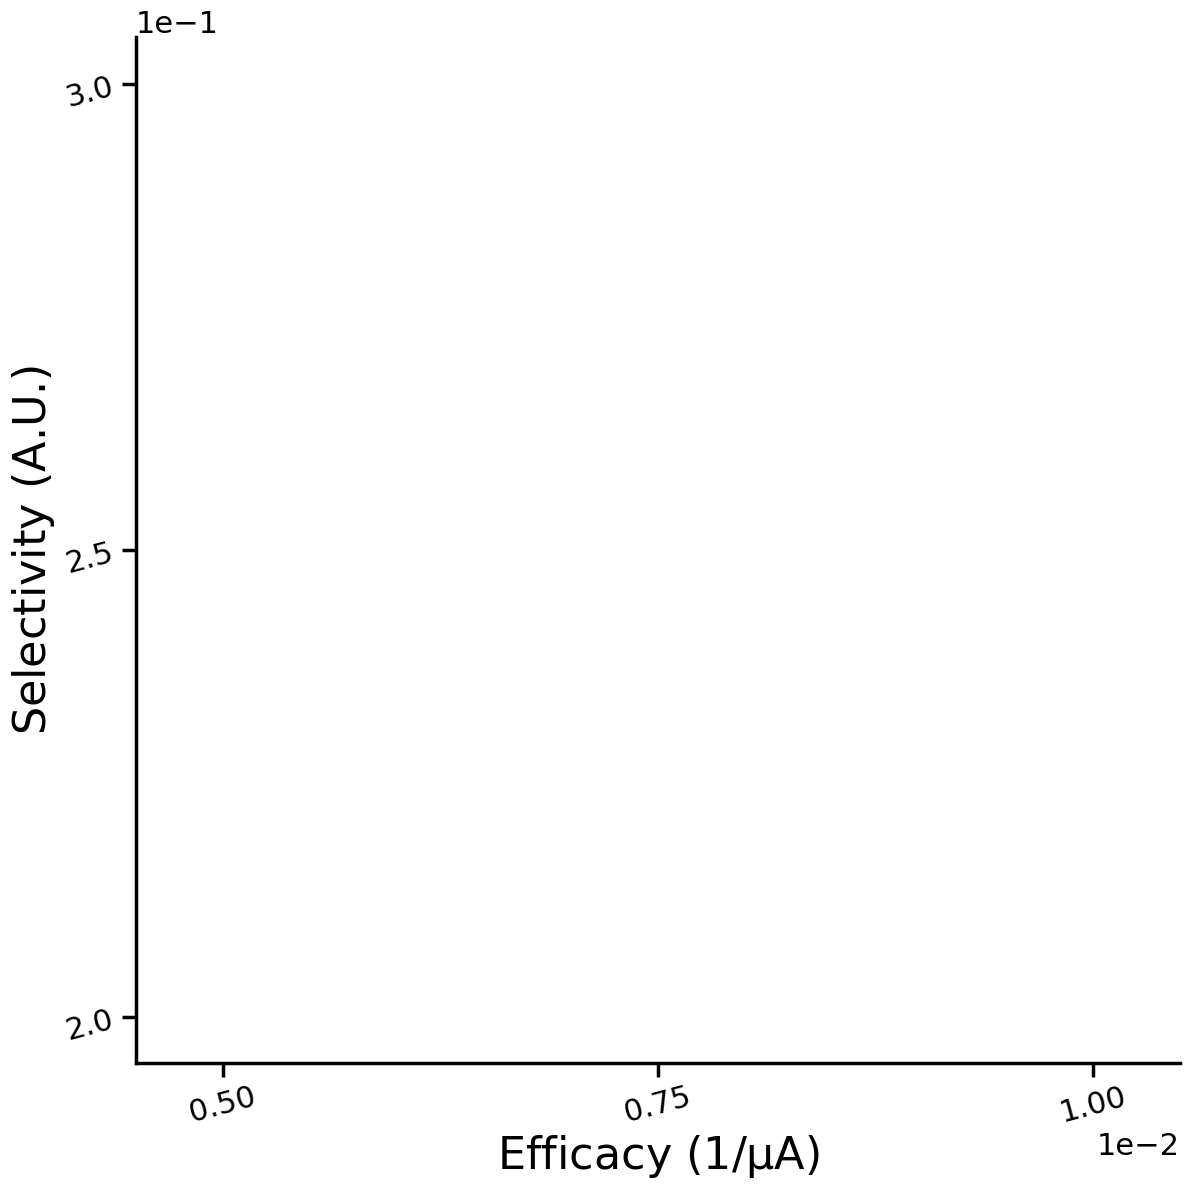

In [185]:
# axis_label_size = 24
# tick_size = 20
fw = "normal"

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), tight_layout=True, squeeze=False)

ax = axes[0, 0]
# key = "diameters"
# keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
# keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

# x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
# y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

# sns.scatterplot(x=x, y=y, ax=ax, color="white")

# for i in range(len(keep_positions_inv)):
#     ax.text(
#         x[i]+0.0001,
#         y[i]+0.0005,
#         keep_positions_inv_adj[i],
#         horizontalalignment='left',
#         size='large',
#         color='black',
#         weight='semibold',
#         rotation=45,
#         wrap=True
#     )

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

ax.set_xlim(left=0.45/100, right=1.05 / 100)
ax.set_ylim(bottom=1.95/10, top=3.05/10)
ax.set_yticks(np.array([2, 2.5, 3]) / 10)
ax.set_xticks(np.array([0.5, 0.75, 1]) / 100)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/plane-shield.svg", dpi=600)

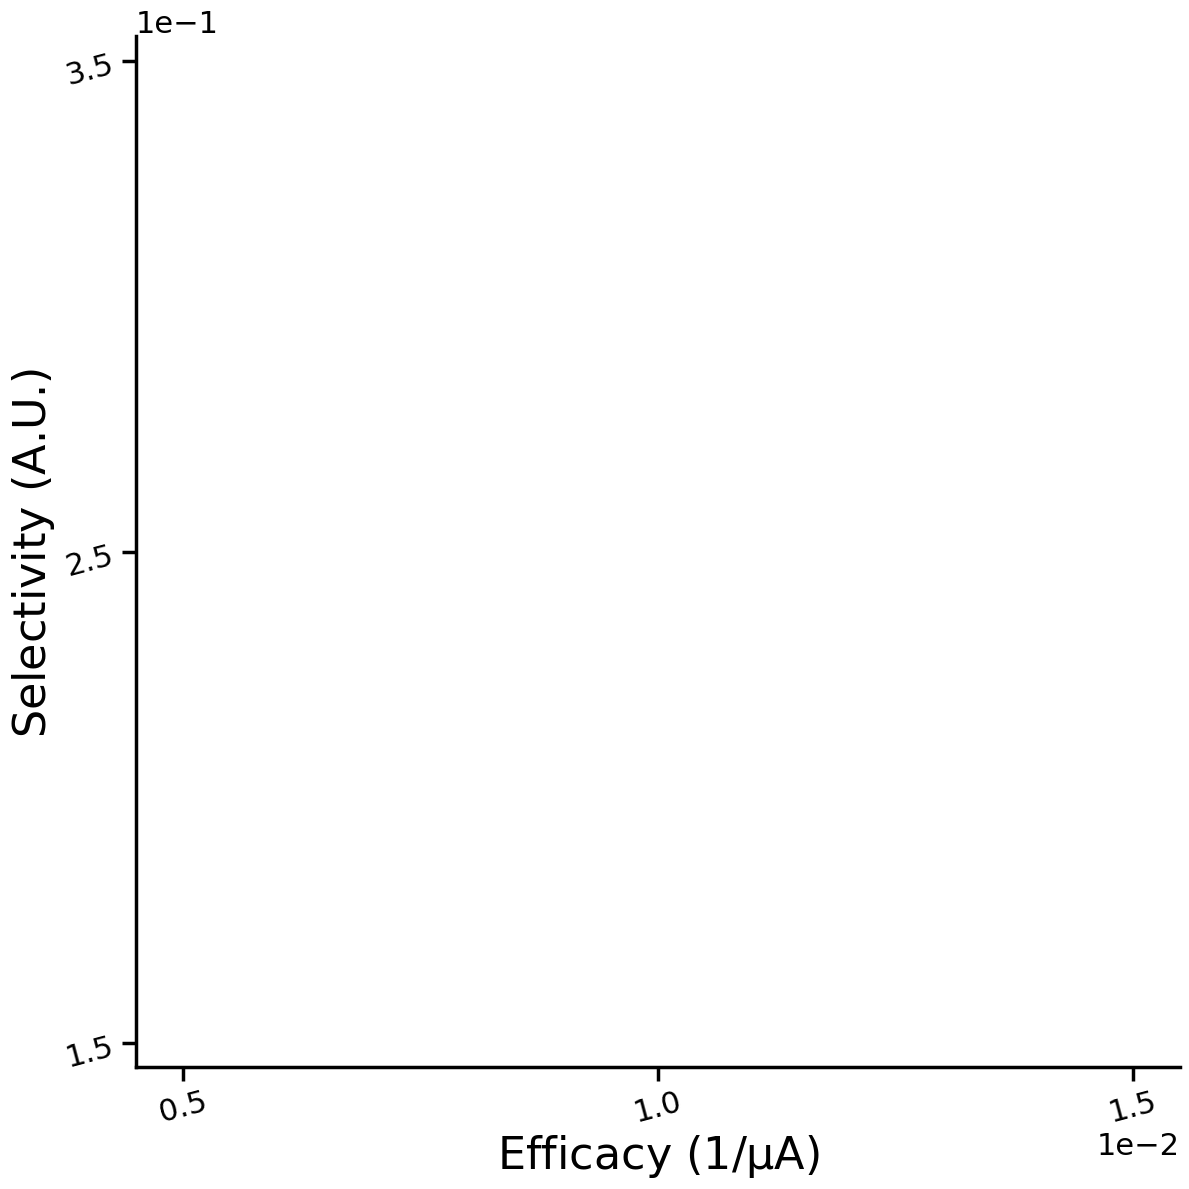

In [191]:
axis_label_size = 42
tick_size = 32
# fw = "normal"
off_len, off_width = 0, 0

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 24), tight_layout=True, squeeze=False)

ax = axes[0, 0]
key = "diameters"
# keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
# keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

# x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
# y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

# sns.scatterplot(x=x, y=y, ax=ax, color="white")

# for i in range(len(keep_positions_inv)):
#     ax.text(
#         x[i]+0.0001,
#         y[i]+0.0005,
#         keep_positions_inv_adj[i],
#         horizontalalignment='left',
#         size='large',
#         color='black',
#         weight='semibold',
#         rotation=45,
#         wrap=True
#     )

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len + off_len,
    width=marker_width + off_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len + off_len,
    width=marker_width + off_width
)
ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

ax.set_ylim(bottom=1.45/10, top=3.55/10)
ax.set_yticks(np.array([1.5, 2.5, 3.5]) / 10)

ax.set_xlim(left=0.45/100, right=1.55 / 100)
ax.set_xticks(np.array([0.5, 1, 1.5]) / 100)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/plane-size.svg", dpi=600)